In [9]:
import seaborn as sns
from sklearn.linear_model import LogisticRegression as LOG, LinearRegression as LR, Ridge
from sklearn.model_selection import cross_validate as cv, cross_val_predict as cvp
from sklearn.multioutput import MultiOutputClassifier as MOC
from sklearn.tree import DecisionTreeClassifier as DTC
import sklearn
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForMaskedLM
from sudoku import Sudoku
import numpy as np
import pandas as pd
import torch 
from tqdm import tqdm
from sklearn.metrics import *
import seaborn as sns
from nnsight import NNsight
from umap import UMAP
import time
import random
import warnings
import gc
from nnsight import LanguageModel, util
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "plotly_mimetype" 
from nnsight import LanguageModel, util
import einops
# Suppress specific FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

try:
    del model
    gc.collect()
except:
    pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

model_id = "answerdotai/ModernBERT-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForMaskedLM.from_pretrained(model_id)

model = model.to(device)

def get_model():
    try:
        del model
        gc.collect()
        torch.cuda.empty_cache()
    except:
        pass
        
    gc.collect()
    torch.cuda.empty_cache()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

    model_id = "answerdotai/ModernBERT-large"
    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForMaskedLM.from_pretrained(model_id)
    
    model = model.to(device)
    return model

In [195]:
import numpy as np
from tqdm import tqdm
from sudoku import Sudoku

# Create a 9x9 mask matrix
zero = np.ones((9, 9), dtype=int)


zero[4, 4] = 1
def get_board(corr_loc):
    puzzle = Sudoku(3, seed=np.random.rand()).difficulty(10**(-9))
    a = np.array(puzzle.board)
    #a*=zero
    a = a.astype(str)

    #random_numbers = np.random.randint(1, 10, size=a.shape)  # Random numbers from 1 to 9
    #a[a == "0"] = "[PAD]"#random_numbers[array == 0]  # Replace zeros

    center = a[4,4]
    a[4, 4] = '[MASK]'
    
    #return a, int(center)
    prompt = '\n'.join(' '.join(row) for row in a)
    #prompt = " " + prompt + " "

    a[corr_loc]=a[corr_loc[0]][corr_loc[1]+1]

    corr_prompt = '\n'.join(' '.join(row) for row in a)
    #corr_prompt = " "+ corr_prompt+ " "
    
    return prompt, int(center), corr_prompt


X, y = [], []

for _ in tqdm(range(32)):
    prompt, center, corr = get_board(corr_loc=(4,0))
    X.append(prompt)
    X.append(corr)
    y.append(center)


100%|██████████| 32/32 [00:00<00:00, 285.12it/s]


In [197]:
print(X[0])

8 9 3 2 1 5 4 6 7
2 1 4 7 9 6 8 3 5
5 6 7 4 3 8 2 9 1
7 3 5 1 4 9 6 8 2
6 2 8 5 [MASK] 3 9 1 4
1 4 9 6 8 2 5 7 3
3 5 2 8 6 7 1 4 9
9 8 1 3 2 4 7 5 6
4 7 6 9 5 1 3 2 8


In [105]:
def get_prediction(prompt):
  with torch.no_grad():
    text = prompt
    inputs = tokenizer(text, return_tensors="pt")
    for i in inputs:
      inputs[i] = inputs[i].to(device)

    outputs = model(**inputs)

    masked_index = inputs["input_ids"][0].tolist().index(tokenizer.mask_token_id)
    #print(masked_index)
    predicted_token_id = outputs.logits[0, masked_index].argmax(axis=-1)
    predicted_token = tokenizer.decode(predicted_token_id)

    if predicted_token in ['\n', '[SEP]', ',', '[UNK]']:
        predicted_token = "0"
    return int(predicted_token)

pred=[]
for p in tqdm(X[1::2]):
    pred.append(get_prediction(p))

100%|██████████| 32/32 [00:11<00:00,  2.70it/s]


In [189]:
def get_prediction(prompt):
  with torch.no_grad():
    text = prompt
    inputs = tokenizer(text, return_tensors="pt")
    for i in inputs:
      inputs[i] = inputs[i].to(device)

    outputs = model(**inputs)

    masked_index = inputs["input_ids"][0].tolist().index(tokenizer.mask_token_id)
    #print(masked_index)
    predicted_token_id = outputs.logits[0, masked_index].argmax(axis=-1)
    predicted_token = tokenizer.decode(predicted_token_id)

    if predicted_token in ['\n', '[SEP]', ',', '[UNK]']:
        predicted_token = "0"
    return int(predicted_token)


def prep(X, y):
    # Tokenize the inputs
    prompts = [X[j] for j in range(4)
    ]

    # Answers are each formatted as (correct, incorrect):
    answers=[]
    l = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    for i in range(2):
        loc = l.copy()
        loc.remove(y[i])

        t = (" "+str(y[i]), " "+str(np.random.choice(loc)))
        tt = (" "+str(y[i]), " "+str(np.random.choice(loc)))
        answers.append(t)
        answers.append(tt)
    
    #print(tokenizer(prompts[0], return_tensors="pt")["input_ids"][0], tokenizer(prompts[0], return_tensors="pt")["input_ids"][0].shape)
    #print(tokenizer(prompts[1], return_tensors="pt")["input_ids"][0], tokenizer(prompts[1], return_tensors="pt")["input_ids"][0].shape)
    clean_tokens = tokenizer(prompts, return_tensors="pt")["input_ids"]
    # The associated corrupted input is the prompt after the current clean prompt
    # for even indices, or the prompt prior to the current clean prompt for odd indices
    corrupted_tokens = clean_tokens[
        [(i + 1 if i % 2 == 0 else i - 1) for i in range(len(clean_tokens))]
    ]

    # Tokenize answers for each prompt:
    answer_token_indices = torch.tensor(
        [
            [tokenizer(answers[i][j])["input_ids"][1] for j in range(2)]
            for i in range(len(answers))
        ]
    )
    return clean_tokens, corrupted_tokens, answer_token_indices

prep(X, y)
def get_logit_diff(logits, answer_token_indices=None):
    with torch.no_grad():
        logits = logits[:, 45, :]
        #print(logits.shape)a
        correct_logits = logits.gather(1, answer_token_indices[:, 0].unsqueeze(1))
        incorrect_logits = logits.gather(1, answer_token_indices[:, 1].unsqueeze(1))
        return (correct_logits - incorrect_logits).mean()
    
def baseline(clean, corrupted, answer_token_indices):
    with torch.no_grad():
        clean_logits = model.trace(clean, trace=False).logits.cpu()
        corrupted_logits = model.trace(corrupted, trace=False).logits.cpu()
        
        CLEAN_BASELINE = get_logit_diff(clean_logits, answer_token_indices).item()
        print(f"Clean logit diff: {CLEAN_BASELINE:.4f}")
        
        CORRUPTED_BASELINE = get_logit_diff(corrupted_logits, answer_token_indices).item()
        print(f"Corrupted logit diff: {CORRUPTED_BASELINE:.4f}")

        return clean_logits, corrupted_logits, CLEAN_BASELINE, CORRUPTED_BASELINE
    
def ioi_metric(
    logits,
    answer_token_indices=None,  
    CLEAN_BASELINE=None,
    CORRUPTED_BASELINE=None,
):
    return (get_logit_diff(logits, answer_token_indices) - CORRUPTED_BASELINE) / (
        CLEAN_BASELINE - CORRUPTED_BASELINE
    )

def patch(model, clean_tokens, corrupted_tokens, ans, cl_base, cr_base):
    clean_out = []
    corrupted_out = []
    corrupted_grads = []

    with model.trace(clean_tokens) as invoker_clean:
        for layer in model.model.layers:

            attn_out = layer.attn.Wo.input.save()
            clean_out.append(attn_out)

    with model.trace(corrupted_tokens) as invoker_corrupted:
        for layer in model.model.layers:
            attn_out = layer.attn.Wo.input
            corrupted_out.append(attn_out.save())

            corrupted_grads.append(attn_out.grad.save())

        logits = model.decoder.output.save()

        value = ioi_metric(logits.cpu(), ans, cl_base, cr_base)
        value.backward()

    return clean_out, corrupted_out, corrupted_grads

def plot(cl_out, cr_out, grads, show=False):
    patching_results = []

    for corrupted_grad, corrupted, clean, layer in zip(
        grads, cr_out, cl_out, range(len(cl_out))
    ):

        residual_attr = einops.reduce(
            corrupted_grad.value[:,45,:] * (clean.value[:,45,:] - corrupted.value[:,45,:]),
            "batch (head dim) -> head",
            "sum",
            head = 16,
            dim = 64,
        )

        patching_results.append(
            residual_attr.detach().cpu().numpy()
        )

    if show:
        fig = px.imshow(
        patching_results,
        color_continuous_scale="RdBu",
        color_continuous_midpoint=0.0,
        title="Attribution Patching Over Attention Heads",
        labels={"x": "Head", "y": "Layer","color":"Norm. Logit Diff"},

        )

        fig.show()
    return patching_results

In [190]:
dic={}
for fold in range(3):
    dic[fold]={}
    for i in range(9):
        for j in range(1):
            dic[fold][(i,j)] = []

            X, y = [], []

            for _ in tqdm(range(32)):
                prompt, center, corr = get_board(corr_loc=(i,j))
                X.append(prompt)
                X.append(corr)
                y.append(center)

            torch.cuda.empty_cache()
            model = get_model()
            model = NNsight(model)

            clean, corr, ans = prep(X, y)

            cl_log, cr_log, cl_base, cr_base = baseline(clean, corr, ans)
            ioi_metric(cl_log, ans, cl_base, cr_base)
            print(f"Clean Baseline is 1: {ioi_metric(cl_log, ans, cl_base, cr_base)}")
            print(f"Corrupted Baseline is 0: {ioi_metric(cr_log, ans, cl_base, cr_base)}")

            cl_out, cr_out, grads = patch(model, clean, corr, ans, cl_base, cr_base)
            res = plot(cl_out, cr_out, grads, show=False)

            dic[fold][(i,j)] = res

100%|██████████| 32/32 [00:00<00:00, 259.73it/s]


Clean logit diff: 8.6216
Corrupted logit diff: 8.4658
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 262.37it/s]


Clean logit diff: 4.9333
Corrupted logit diff: 4.9903
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


100%|██████████| 32/32 [00:00<00:00, 88.36it/s] 


Clean logit diff: 9.4344
Corrupted logit diff: 9.2727
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 296.19it/s]


Clean logit diff: 7.0720
Corrupted logit diff: 7.5092
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


100%|██████████| 32/32 [00:00<00:00, 243.63it/s]


Clean logit diff: 6.4849
Corrupted logit diff: 8.9638
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


100%|██████████| 32/32 [00:00<00:00, 310.29it/s]


Clean logit diff: 6.4856
Corrupted logit diff: 6.4115
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 272.49it/s]


Clean logit diff: 6.2001
Corrupted logit diff: 6.0999
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 271.93it/s]


Clean logit diff: 6.2219
Corrupted logit diff: 6.2111
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 290.08it/s]


Clean logit diff: 6.7980
Corrupted logit diff: 6.7066
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 308.37it/s]


Clean logit diff: 7.4298
Corrupted logit diff: 7.2344
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 210.23it/s]


Clean logit diff: 8.1403
Corrupted logit diff: 8.3187
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


100%|██████████| 32/32 [00:00<00:00, 347.01it/s]


Clean logit diff: 6.3345
Corrupted logit diff: 6.3389
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


100%|██████████| 32/32 [00:00<00:00, 244.40it/s]


Clean logit diff: 6.9017
Corrupted logit diff: 6.6223
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 308.26it/s]


Clean logit diff: 7.5450
Corrupted logit diff: 7.4710
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 288.92it/s]


Clean logit diff: 5.9639
Corrupted logit diff: 5.9106
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 319.50it/s]


Clean logit diff: 5.6256
Corrupted logit diff: 5.8354
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


100%|██████████| 32/32 [00:00<00:00, 272.83it/s]


Clean logit diff: 8.5386
Corrupted logit diff: 8.5287
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 102.13it/s]


Clean logit diff: 5.8117
Corrupted logit diff: 5.7704
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 110.71it/s]


Clean logit diff: 6.4402
Corrupted logit diff: 6.4605
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


100%|██████████| 32/32 [00:00<00:00, 114.10it/s]


Clean logit diff: 6.8487
Corrupted logit diff: 6.7256
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 122.55it/s]


Clean logit diff: 8.6763
Corrupted logit diff: 8.7191
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


100%|██████████| 32/32 [00:00<00:00, 112.08it/s]


Clean logit diff: 8.5850
Corrupted logit diff: 8.6205
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


100%|██████████| 32/32 [00:00<00:00, 108.48it/s]


Clean logit diff: 6.5789
Corrupted logit diff: 6.1056
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 139.84it/s]


Clean logit diff: 7.5748
Corrupted logit diff: 7.4779
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 135.52it/s]


Clean logit diff: 7.5719
Corrupted logit diff: 7.5556
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 112.39it/s]


Clean logit diff: 6.5167
Corrupted logit diff: 6.4614
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: 0.0


100%|██████████| 32/32 [00:00<00:00, 266.65it/s]


Clean logit diff: 5.7719
Corrupted logit diff: 5.8129
Clean Baseline is 1: 1.0
Corrupted Baseline is 0: -0.0


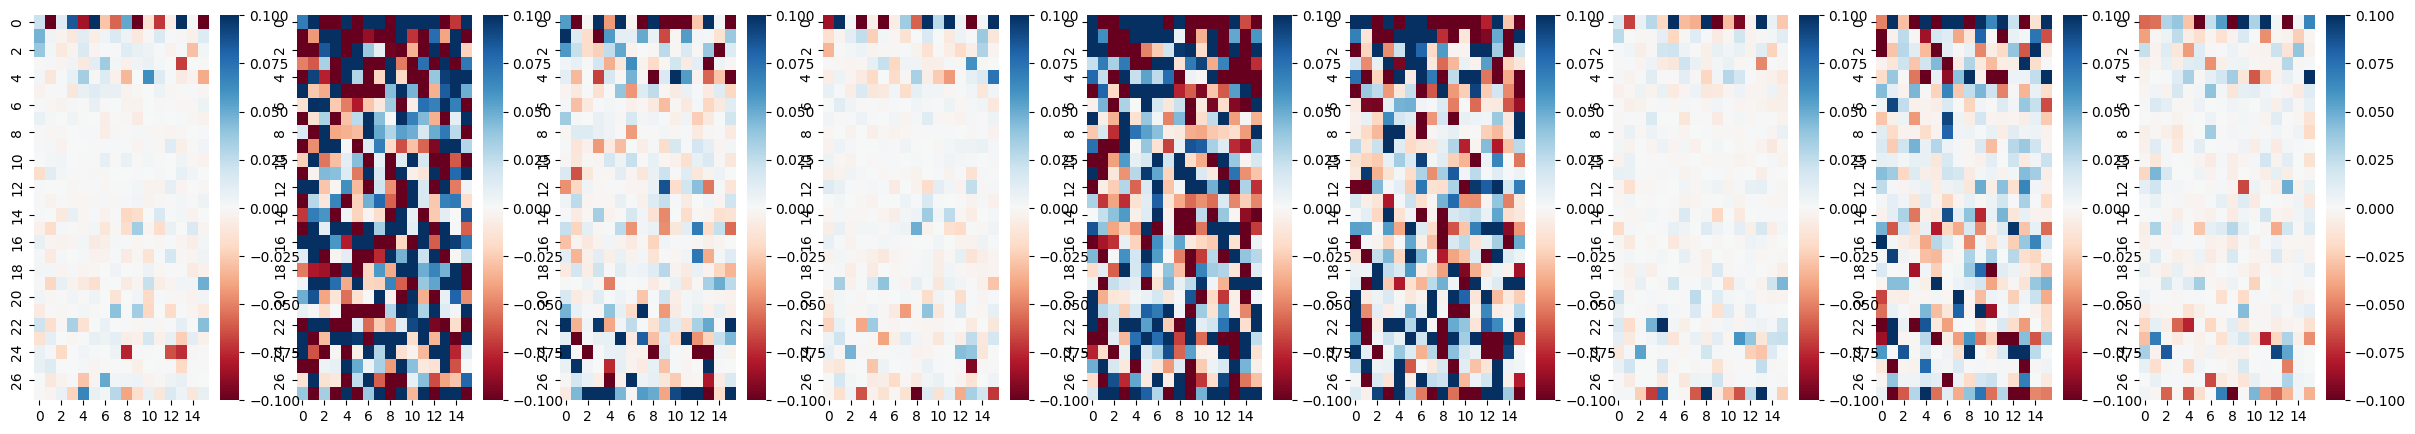

In [56]:
fig, ax = plt.subplots(1, 9, figsize=(30, 5))
for c,i in enumerate(dic):
    sns.heatmap(dic[i], ax=ax[c], cmap="RdBu", center=0, vmax=0.1, vmin=-0.1)

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:202: RuntimeWarning:

All-NaN slice encountered

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\matrix.py:207: RuntimeWarning:

All-NaN slice encountered



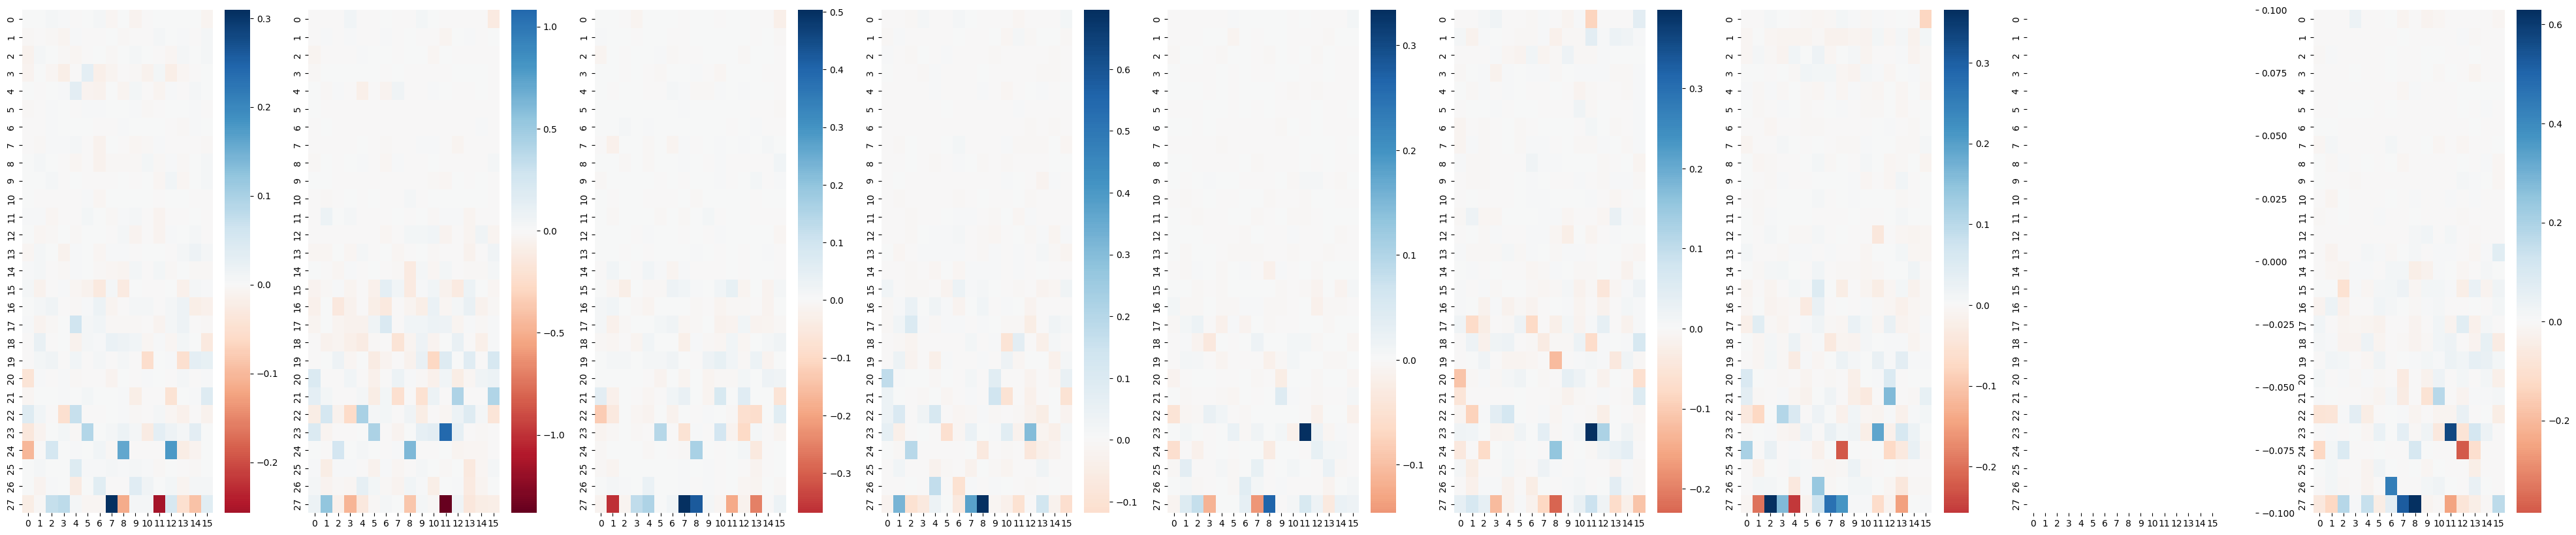

In [152]:
fig, ax = plt.subplots(1, 9, figsize=(50, 10))
for c,i in enumerate(dic[1]):
    sns.heatmap(dic[1][i], ax=ax[c], cmap="RdBu", center=0)

In [191]:
a = np.array(list(dic[0].values()))
b = np.array(list(dic[1].values()))
b = np.nan_to_num(b, nan=0)
c = np.array(list(dic[2].values()))
c = np.nan_to_num(c, nan=0)

In [192]:
d = a+b+c
d = d/3

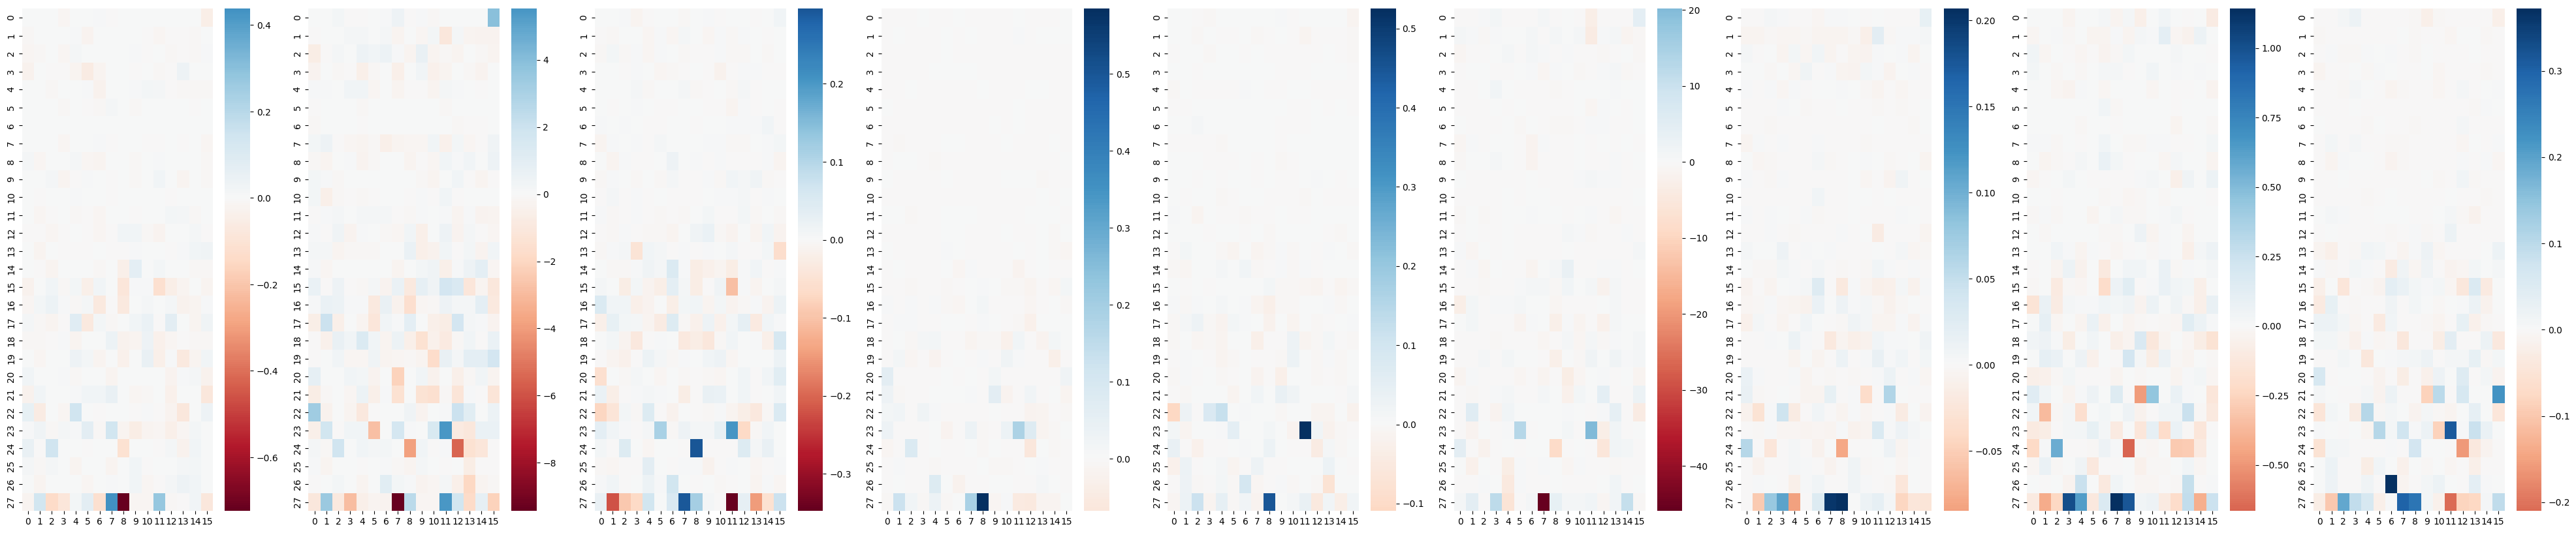

In [ ]:
#Dont re-run
fig, ax = plt.subplots(1, 9, figsize=(50, 10))
for c,i in enumerate(d):
    sns.heatmap(d[c], ax=ax[c], cmap="RdBu", center=0)

In [ ]:
fig.savefig("viol.png", dpi=300, bbox_inches="tight")

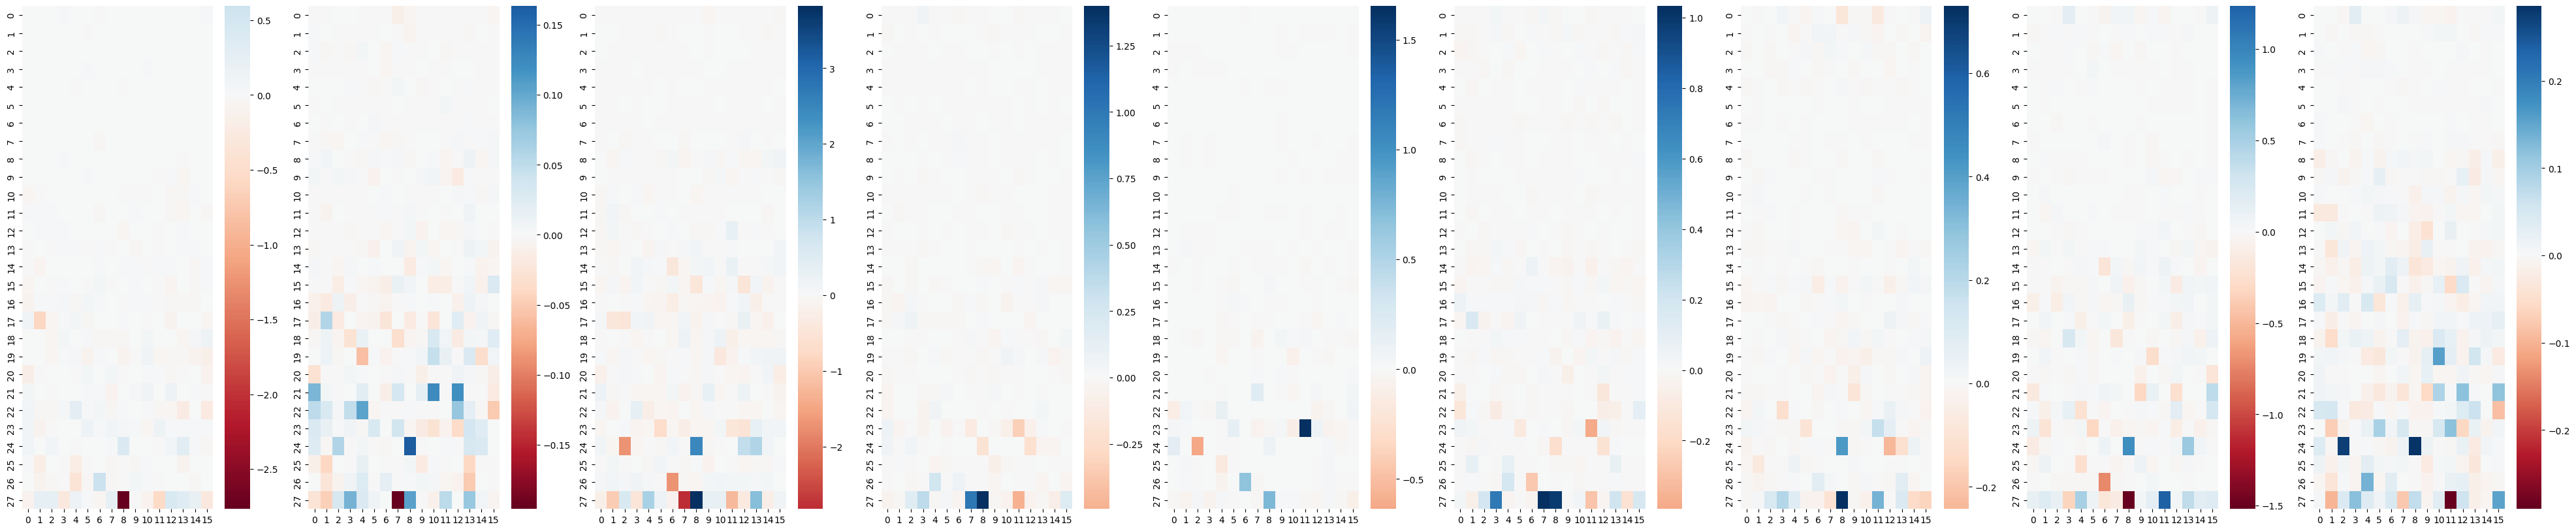

In [194]:
fig, ax = plt.subplots(1, 9, figsize=(50, 10))
for c,i in enumerate(d):
    sns.heatmap(d[c], ax=ax[c], cmap="RdBu", center=0)

fig.savefig("viol.png", dpi=300, bbox_inches="tight")